## Calculate growth rates given allele counts for the saturation mutagenesis library (in all four TYMS backgrounds)

Collect up allele counts from all experiments (replicates and TYMS backgrounds), calculate growth rates, and assess:
  1. Initial library completeness
  2. The correspondence in measured growth rate amongst replicates.
  3. The correspondence between growth rates measured by sequencing and by individual plate reader      measurements
  4. The distribution of growth rate effects for each TYMS background 
    
The sequencing counts for this experiment derive from experiments across four different experimental dates. Prior to growth rate fitting (in this notebook) the sequencing reads were filtered by Q-score (all reads were required to be q-score > 20), and assigned to a particular DHFR mutation or WT. The mutation counts were then adjusted by subtracting a correction that accounts for the expected number of reads simply due to errors in sequencing the WT (which represents the largest portion of our library). This "read-hopping" correction takes into account the q-score cutoff (20 or better), the number of WT reads at a given time point, and the number of nucleotide substitutions seperating the mutation of interest from WT. Finally, the adjusted sequencing counts were randomly subsampled to give equivalent coverage across all sequencing experiments, to ensure a similar dynamic range and level of noise across replicates.

April 2022 - K. Reynolds and T. Nguyen

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats 
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
import copy

import numpy as np
import pickle

#set up the plotting environment
import plot_style
plot_style.change_plot_defaults()

### Specify initial parameters of the experiment

In [2]:
#define the size of the mutational space
#and specify the sequence (and range) of each sublibrary
Npos = 159 
AA = 'GAVLMIFYWKRHDESTCNQP*' #here we order the amino acids by biochemical similarity

NAA = len(AA)
wt_aa_sequence= {}
wt_aa_sequence['sl1']= 'MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPV'
wt_aa_sequence['sl2']= 'IMGRHTWESIGRPLPGRKNIILSSQPGTDDRVTWVKSVDE'
wt_aa_sequence['sl3']= 'AIAACGDVPEIMVIGGGRVYEQFLPKAQKLYLTHIDAEVE'
wt_aa_sequence['sl4']= 'GDTHFPDYEPDDWESVFSEFHDADAQNSHSYCFEILERR*'
wt_aa_seqfull = wt_aa_sequence['sl1']+wt_aa_sequence['sl2']+wt_aa_sequence['sl3']+wt_aa_sequence['sl4']

#amino acid positions included in each sublibrary
aa_pos = [np.arange(1,40+1),np.arange(41,80+1),\
        np.arange(81,120+1),np.arange(121,160+1)]
Nsl = len(aa_pos)

#define the experimental variables 
TYMS_mut = ['WT','Q33S','R166Q']
ts_col = ['k','c','r']
time_points = [0,4,8,12,20,24] #time point
timeName = ['t0','t4','t8','t12','t20','t24']
Ntp = len(time_points)
Nrep = 3
reps=np.arange(1,3+1)


#define the input data files
#these contain raw counts for each experiment after q-score filtering
#adjustment for WT read hopping (Hamming correction), and in some cases,
#downsampling the data so that all replicates have approximately equivalent
#read depth
countsDir = '210514_mutantCounts/'
inputData = ['200920_counts_nonsubsampled_WT.txt',    #repeats 2+3, WT TYMS background
             '200920_counts_nonsubsampled_R166Q.txt', #repeats 2+3, R166Q TYMS background
             '210211_counts_subsampled_WT.txt',       #repeat 1, WT TYMS background
             '210211_counts_subsampled_R166Q.txt',    #repeat 1, R166Q background
             '210416_counts_subsampled_Q33S.txt']     #repeats 1-3, Q33S background

#Also read in the bulk culture growth rates (as measured by the turbidostat)
#we use these to adjust for the number of generations each culture experiences
bulk_grates = {}
for ts in TYMS_mut:
    bulk_grates[ts] = np.zeros([Nrep,Nsl])
    
tstat_data = 'Input/tstat_bulkGR_summary.txt'
flines = open(tstat_data).readlines()
for line in flines[1:]:
    sp = line.split()
    r = int(sp[2])-1; sl = int(sp[0])-1
    bulk_grates[sp[1]][r,sl] = float(sp[3]) 
    
#Read in data on a set of well-characterized DHFR point mutants:
calib_mut = ['WT','M42F','L54I','W22H','F31V','G121V','D27N','L28F','L28Y','T113V','F31Y','L54F']
dhfr_kcat, dhfr_Km, dhfr_kcat_std, dhfr_Km_std  = {}, {}, {}, {}

for line in open('Input/kinetics_dhfr.txt').readlines():
    sp = line.split()
    if sp[0] in calib_mut:
        dhfr_kcat[sp[0]] = float(sp[1]) 
        dhfr_Km[sp[0]] = float(sp[2]) 
        if len(sp) > 3:
            dhfr_kcat_std[sp[0]] = float(sp[3])
            dhfr_Km_std[sp[0]] = float(sp[4])
        else:
            dhfr_kcat_std[sp[0]] = np.nan
            dhfr_Km_std[sp[0]] = np.nan

In [3]:
#container for the raw counts. 
mutcounts = {}
mutcounts_maskWT = {}
for ts in TYMS_mut:
    mutcounts[ts] = np.zeros([Nrep,Npos,NAA,Ntp])
    mutcounts_maskWT[ts] = np.zeros([Nrep,Npos,NAA,Ntp])
    
#container for the WT reference counts (specific to each sublibrary, replicate, and TYMS background)
WTcounts = {}
for ts in TYMS_mut:
    WTcounts[ts] = np.zeros([Nrep,Nsl,Ntp])

### 2. Fill in the counts data structures from the data input files

In [4]:
#fill in counts data
for dfile in inputData:
    flines = open(countsDir+dfile).readlines()
    for line in flines[1:]:
        sp = line.split()
        ts = sp[2]
        rep = int(sp[1])-1
        pos_ix = int(sp[0][1:-1])-1
        aa_ix = AA.index(sp[0][-1])
        sl = [s for s in range(4) if pos_ix+1 in aa_pos[s]][0]
        
        if pos_ix < 159:
            WTcounts[ts][rep,sl,:] = sp[9:15]
            if (wt_aa_seqfull[pos_ix] == sp[0][-1]):
                mutcounts[ts][rep,pos_ix,aa_ix,:] = sp[9:15]
                mutcounts_maskWT[ts][rep,pos_ix,aa_ix,:] = [np.NAN,np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
            else:
                mutcounts[ts][rep,pos_ix,aa_ix,:] = sp[3:9]
                mutcounts_maskWT[ts][rep,pos_ix,aa_ix,:] = sp[3:9]


### Generate normalized frequencies 
For each allele, we normalize by WT and the relative frequency of mut/allele at t=0
Along the way, we also filter the data to indicate data points where the reads fall below a threshold of detection (minimum of 10 read counts). (these are marked as nan values in the matrices of normalized and log-normalized allele frequencies)

In [5]:
mutcounts_norm, mutcounts_lognorm = {},{}
for ts in TYMS_mut:
    mutcounts_norm[ts] = np.zeros_like(mutcounts[ts])
    mutcounts_lognorm[ts] = np.zeros_like(mutcounts[ts])
thresh_detect = 10  #threshold for what we consider as "present" in the library

for ts in TYMS_mut:
    for rep in range(Nrep):
        for pos_ix in range(Npos):
            for aa_ix in range(NAA):
                sl = [s for s in range(4) if pos_ix+1 in aa_pos[s]][0]
                for i,tp in enumerate(time_points):
                    if mutcounts[ts][rep,pos_ix,aa_ix,i] <= thresh_detect:
                        mutcounts[ts][rep,pos_ix,aa_ix,i] = np.NAN
                        mutcounts_maskWT[ts][rep,pos_ix,aa_ix,i] = np.NAN
                        mutcounts_norm[ts][rep,pos_ix,aa_ix,i] = np.NAN
                        mutcounts_lognorm[ts][rep,pos_ix,aa_ix,i] = np.NAN
                    else:
                        mutcounts_norm[ts][rep,pos_ix,aa_ix,i] = (mutcounts[ts][rep,pos_ix,aa_ix,i] \
                                                                    /WTcounts[ts][rep,sl,i])/\
                                                                 (mutcounts[ts][rep,pos_ix,aa_ix,0]\
                                                                    /WTcounts[ts][rep,sl,0])
                        mutcounts_lognorm[ts][rep,pos_ix,aa_ix,i] = np.log2(mutcounts_norm[ts][rep,pos_ix,aa_ix,i])
                        

### 3. Examine library completeness

Display heatmaps of the raw counts, and distribution of raw counts at t=0 for each replicate x TYMS background combination

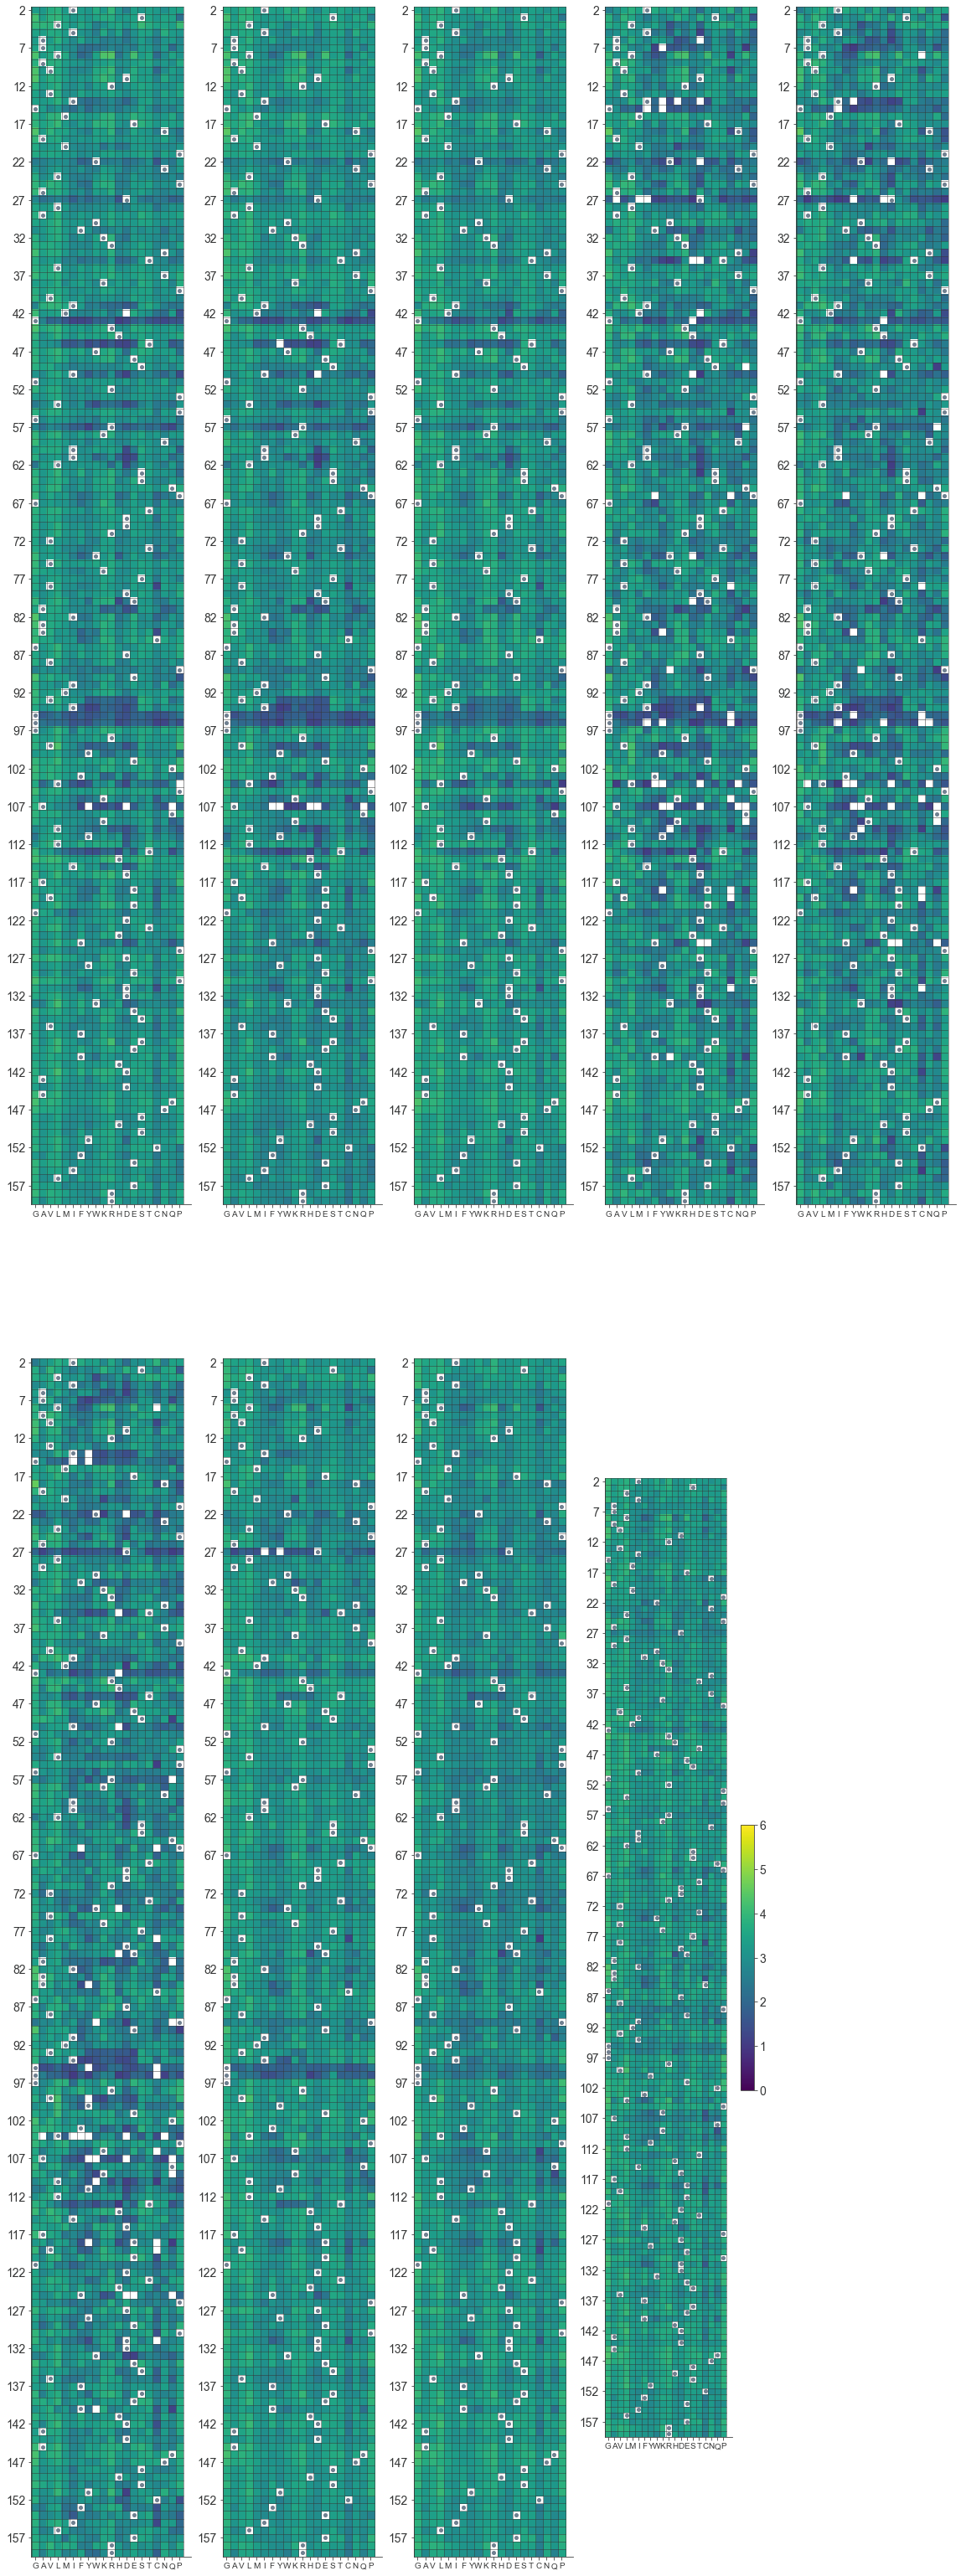

In [6]:
plt.figure(num='h1',figsize = (16,45))
h1_cmap = copy.copy(plt.cm.get_cmap('viridis'))
h1_cmap.set_bad(color='white') 

fig=1
for ts in TYMS_mut:
    for rep in range(Nrep):
        plt.subplot(2,5,fig)
        plt.imshow(np.log10(mutcounts_maskWT[ts][rep,1:,:-1,0]),vmin=0,vmax=6,cmap=h1_cmap,interpolation='none')
        fig += 1
        
        #draw on grey gridlines
        plot_style.grid_maker(mutcounts_maskWT[ts][rep,1:,:-1,0],'h1')
            
        #draw a small dot to indicate the WT AA at each postiion:
        for i,a in enumerate(wt_aa_seqfull[1:-1]):
            aa_ix = AA.index(a)
            plt.plot(aa_ix,i,'o',markersize=4,color='slategrey')
            
        plt.yticks(np.arange(0,Npos-1,5),\
                             labels=np.arange(2,Npos,5))
        plt.xticks(np.arange(0,NAA-1),\
                             labels=AA[:-1],fontsize=10)
        
plt.colorbar(shrink=0.2)
plt.tight_layout()
plt.savefig('Figs/LibraryCompletenessHeatmap_wcolorbar.pdf')

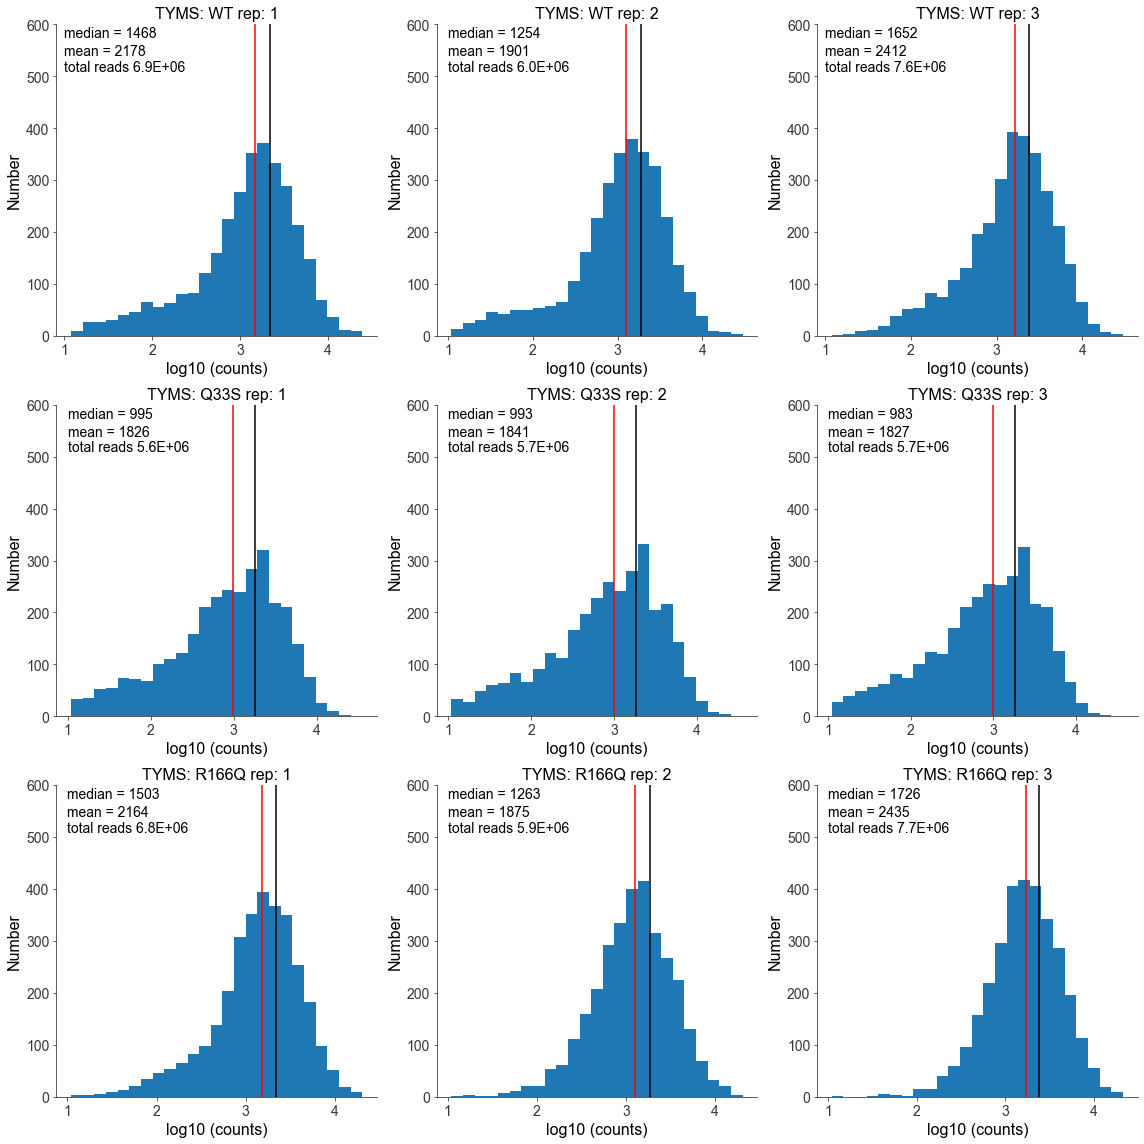

In [7]:
plt.figure(figsize = (16,16))
fig=1
for ts in TYMS_mut:
    for rep in range(Nrep):
        plt.subplot(3,3,fig)
        nan_array = np.isnan(mutcounts_maskWT[ts][rep,:,:,0].flatten())
        plt.hist(np.log10(mutcounts_maskWT[ts][rep,:,:,0].flatten()[~nan_array]),25)
        plt.xlabel('log10 (counts)',fontsize=16); plt.ylabel('Number',fontsize=16)
        plt.ylim([0,600])
        mean = np.nanmean(mutcounts_maskWT[ts][rep,:,:,0].flatten())
        median = np.nanmedian(mutcounts_maskWT[ts][rep,:,:,0].flatten())
        total=np.nansum(mutcounts_maskWT[ts][rep,:,:,0].flatten())
        plt.text(1,540,('mean = %i' % mean),fontsize=14)
        plt.text(1,575,('median = %i ' % median), fontsize=14)
        plt.text(1,510,('total reads %1.1E' % total),fontsize=14)
        plt.plot([np.log10(median),np.log10(median)],[0,600],'r')
        plt.plot([np.log10(mean),np.log10(mean)],[0,600],'k')
        plt.title('TYMS: '+ts+" rep: "+str(rep+1),fontsize=16)
        fig +=1
plt.tight_layout()
plt.savefig('Figs/LibraryCompletenessHisto.pdf')

### Fit relative growth rates

In [8]:
#container for holding the growth rate data
grates = {}
grates_R = {}
grates_icpt = {}
grates_maskWT = {}

for ts in TYMS_mut:
    grates[ts] = np.zeros([Nrep,Npos,NAA])
    grates_R[ts] = np.zeros([Nrep,Npos,NAA])
    grates_icpt[ts] = np.zeros([Nrep,Npos,NAA])
    grates_maskWT[ts] = []
    
#create a mask for the WT amino acid identities 
#(to prevent overcounting of these later)
WTAAmask = np.zeros((Npos,NAA))
for p in range(Npos):
    for a in range(NAA):
        if AA[a] == wt_aa_seqfull[p]:
            WTAAmask[p,a] = 1
            
WTAAmask = (WTAAmask == 1)
    
#To fit growth rates, we consider all samples up to the first 
#timepoint where the number of counts drops below threshold. We only fit growth
#rates for variants with at least 3 time points. 
#
#When fitting, we weight each point by the sample size, to help minimize
#noise from later time points
#
#indicating mutations that are missing at t=0 with -1000
#indicating mutations that are lost too quickly to be fit with -999
for ts in TYMS_mut:
    for rep in range(Nrep):
        for pos in range(Npos):
            for aa_ix in range(NAA):
                data = mutcounts_lognorm[ts][rep,pos,aa_ix,:]
                counts = mutcounts[ts][rep,pos,aa_ix,:]
                nan_array = list(np.isnan(data))
                firstnan = nan_array.index(True) if True in nan_array else Ntp
                
                if firstnan == 0:
                    grates[ts][rep,pos,aa_ix] = -1000
                elif firstnan < 3:
                    grates[ts][rep,pos,aa_ix] = -999
                else:
                    #m,b,r,p,se = stats.linregress(time_points[0:firstnan-1],data[0:firstnan-1])
                    regr = LinearRegression()
                    regr.fit(np.array(time_points[0:firstnan-1]).reshape(-1,1),\
                             np.array(data[0:firstnan-1]).reshape(-1,1) ,\
                             counts[0:firstnan-1])
                    grates[ts][rep,pos,aa_ix] = regr.coef_
                    grates_icpt[ts][rep,pos,aa_ix] = regr.intercept_
                    grates_R[ts][rep,pos,aa_ix] = regr.score(np.array(time_points[0:firstnan-1]).reshape(-1,1),\
                                                             np.array(data[0:firstnan-1]).reshape(-1,1) ,\
                                                             counts[0:firstnan-1])
                    
        grates_maskWT[ts].append(np.ma.array(grates[ts][rep,:,:],mask=WTAAmask,fill_value = np.nan))

### Report statistics on the number of mutations with growth rate data

In [9]:
# for reporting completeness statistics, we consider missense mutations
# at positions 2-159, and omit the WT  
Nmut = np.sum(~(WTAAmask[1:,:-1]))
print('** Total library size: %i missense mutations' % Nmut)
print('**Summary statistics by replicate: **')
for ts in TYMS_mut:
    for rep in range(Nrep):
        print('*************')
        print('TYMS: '+ts+' replicate: '+str(rep)+':')
        missing = np.sum(np.sum(grates[ts][rep,1:,:-1] == -1000))
        null = np.sum(np.sum(grates[ts][rep,1:,:-1] == -999))
        print('missing at t=0: %i,%1.1f%%' % (missing, missing/Nmut*100))
        print('null: %i,%1.1f%%' % (null, null/Nmut*100))
        
print('\n\n')
print('**Summary statistics across replicates for each TYMS background: **')
for ts in TYMS_mut:
    print('*************')
    print('TYMS: '+ts)
    N_allreps = 0
    for p in range(1,Npos):
        for a in range(NAA-1):
            if (np.sum(grates[ts][:,p,a]>-999) > 2) and ~WTAAmask[p,a]:
                N_allreps +=1
    print('Mutations with three replicates: %i,%1.2f%%' % (N_allreps, 100*(N_allreps/(Nmut))))

** Total library size: 3002 missense mutations
**Summary statistics by replicate: **
*************
TYMS: WT replicate: 0:
missing at t=0: 5,0.2%
null: 58,1.9%
*************
TYMS: WT replicate: 1:
missing at t=0: 9,0.3%
null: 57,1.9%
*************
TYMS: WT replicate: 2:
missing at t=0: 0,0.0%
null: 9,0.3%
*************
TYMS: Q33S replicate: 0:
missing at t=0: 49,1.6%
null: 84,2.8%
*************
TYMS: Q33S replicate: 1:
missing at t=0: 41,1.4%
null: 79,2.6%
*************
TYMS: Q33S replicate: 2:
missing at t=0: 43,1.4%
null: 85,2.8%
*************
TYMS: R166Q replicate: 0:
missing at t=0: 2,0.1%
null: 20,0.7%
*************
TYMS: R166Q replicate: 1:
missing at t=0: 0,0.0%
null: 0,0.0%
*************
TYMS: R166Q replicate: 2:
missing at t=0: 0,0.0%
null: 0,0.0%



**Summary statistics across replicates for each TYMS background: **
*************
TYMS: WT
Mutations with three replicates: 2916,97.14%
*************
TYMS: Q33S
Mutations with three replicates: 2841,94.64%
*************
TYMS: R166Q

### Create a plot with representative data for one mutation in three TYMS backgrounds.

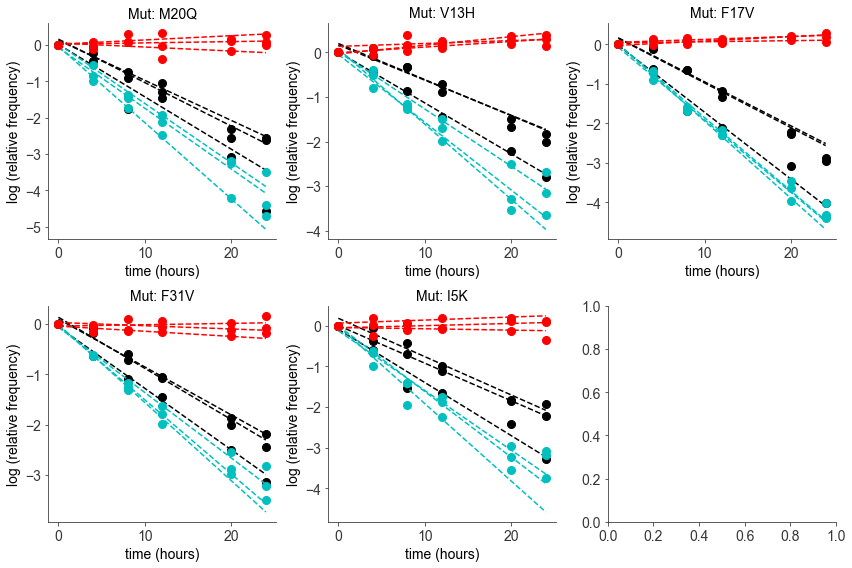

In [10]:
#To get a sense of data quality, we plot relative allele frequency vs. time 
#for a well-characterized point mutant in all three TYMS backgrounds

moi = ['M20Q','V13H','F17V','F31V','I5K']

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs=axs.flatten()
for i,m in enumerate(moi):
    p = int(m[1:-1])-1
    a = AA.index(m[-1])
    for t,ts in enumerate(TYMS_mut):
        for rep in range(3):
            axs[i].plot(time_points,mutcounts_lognorm[ts][rep,p,a,:],'o',color=ts_col[t],ms=8)
            axs[i].plot(time_points,np.array(time_points)*grates[ts][rep,p,a]+grates_icpt[ts][rep,p,a],'--',color=ts_col[t])
    axs[i].set_title(f'Mut: {m}',fontsize=14)
    axs[i].set_xlabel('time (hours)',fontsize=14)
    axs[i].set_ylabel('log (relative frequency)',fontsize=14)

plt.tight_layout()
plt.savefig('Figs/ExampleEpiMut.pdf')

### Rescale the relative growth rates 

We rescale the growth rates to fall on a zero(minimum growth rate) to one (WT-like growth) scale.
We also adjust the growth rates to account for vial-to-vial variation in culture doublings (bulk culture growth rates). 

First, examine the bulk culture growth rates for all replicates of the experiment. These are obtained by fitting the OD600 vs time measurements on each turbidostat growth interval, and averaging across the duration of the experiment. 

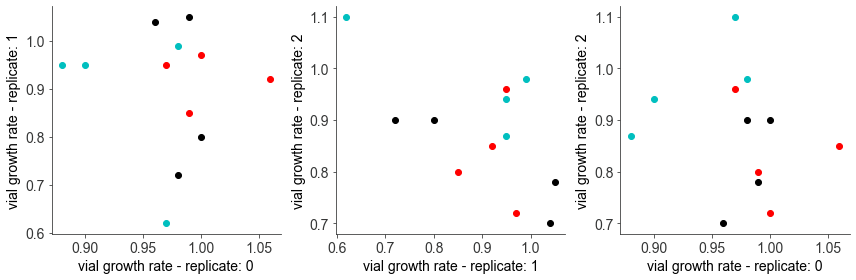

In [11]:
#are there correlations in the bulk culture growth rates?
#not so much. Looks like noise(?though the magnitude is pretty large?) around a growth rate near 0.9
rep_pairs = [[0,1],[1,2],[0,2]]
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i,ts in enumerate(TYMS_mut):
    for p in range(len(rep_pairs)):
        ax[p].plot(bulk_grates[ts][rep_pairs[p][0],:],bulk_grates[ts][rep_pairs[p][1],:],'o',\
                 markersize=6,color=ts_col[i])
        ax[p].set_xlabel("vial growth rate - replicate: %i" % rep_pairs[p][0], fontsize=14)
        ax[p].set_ylabel("vial growth rate - replicate: %i" % rep_pairs[p][1], fontsize=14)
        
plt.tight_layout()

Now we scale and normalize the growth rates as follows:
    
   1)  The relative growth rates (in units of per hour) are divided by the bulk culture growth rate 
       (in generations per hour) to put the growth rate in units of per generation. This helps account
       for vial to vial variation in culture growth rate.
        
   2)  The relative growth rates are scaled such that the relative growth rate for D27N in the background of Q33S TYMS is zero (D27N is near catalytically dead), and WT is one:  $ gr_{scaled} = \frac{gr + gr_{D27N}}{gr_{D27N}}$

In [12]:
#create a container for the scaled growth rates
grates_scaled = {}
for ts in TYMS_mut:
    grates_scaled[ts]=np.zeros_like(grates[ts])

#scale by the bulk culture doubling time
for ts in TYMS_mut:
    for rep in range(Nrep):
        for pos_ix in range(Npos):
            for aa_ix in range(NAA):
                #set WT entries to nan (to avoid over-representation)
                if WTAAmask[p,a]:
                    grates_scaled[ts][rep,pos_ix,aa_ix] = np.nan
                elif grates[ts][rep,pos_ix,aa_ix] > -999:
                    sl = [s for s in range(4) if pos_ix+1 in aa_pos[s]][0]
                    grates_scaled[ts][rep,pos_ix,aa_ix] = grates[ts][rep,pos_ix,aa_ix]/bulk_grates[ts][rep,sl]
                #set growth rates that could not be fit to nan
                else:
                    grates_scaled[ts][rep,pos_ix,aa_ix] = np.nan
                    
#normalize to the D27N growth rate
D27N_grate = np.nanmean(grates_scaled['Q33S'][:,26,AA.index('N')])
print('D27N baseline measurements:')
print(grates_scaled['Q33S'][:,26,AA.index('N')])
for ts in TYMS_mut:
    grates_scaled[ts]=(grates_scaled[ts]-D27N_grate)/abs(D27N_grate)

D27N baseline measurements:
[-0.36889683 -0.31958    -0.19970667]


### Compare the relative growth rates across replicate experiments

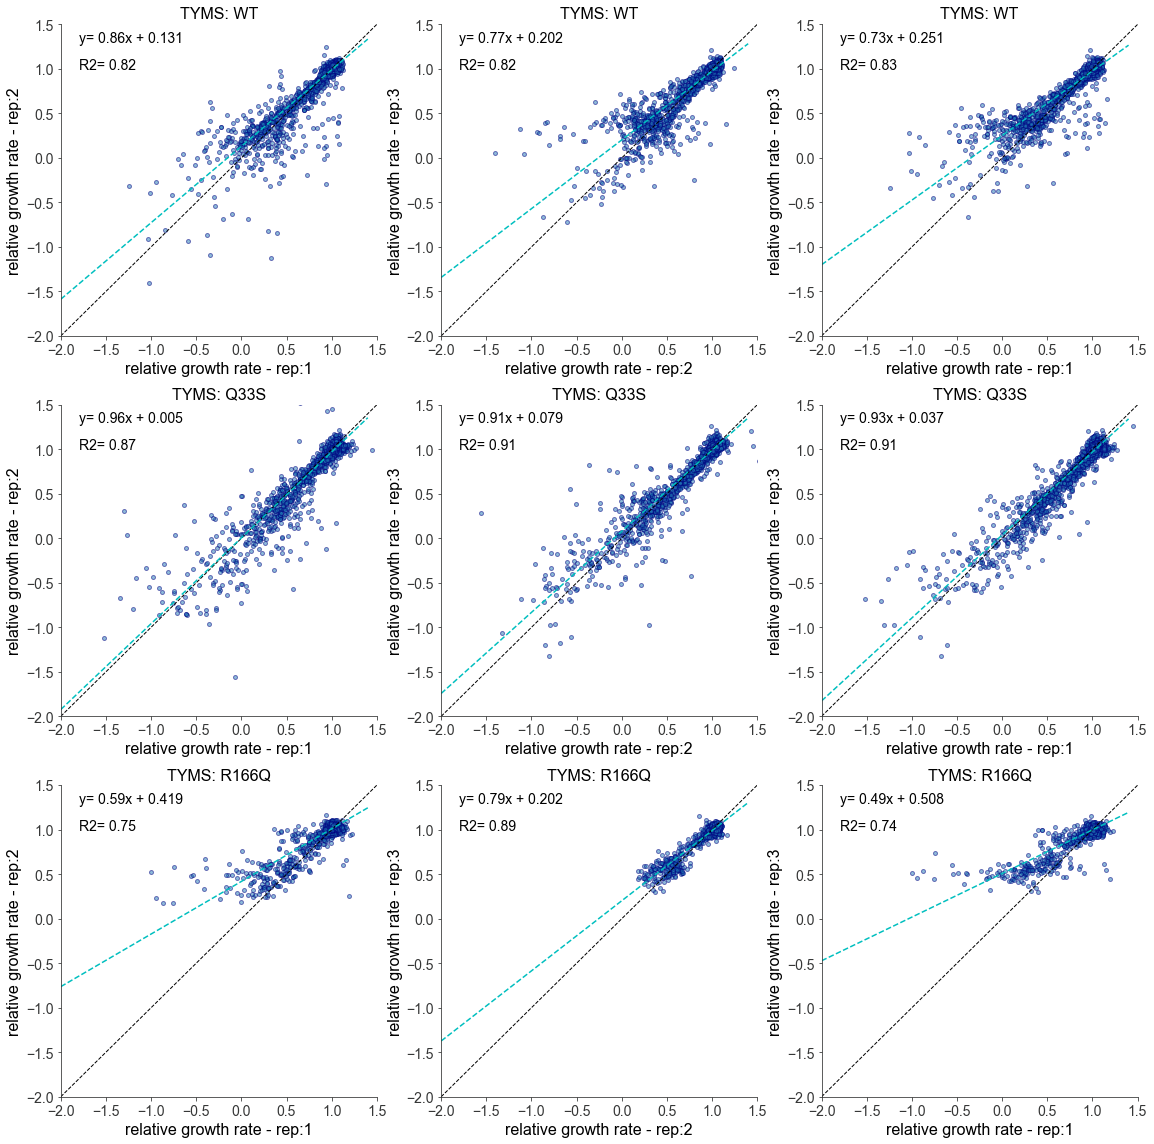

In [13]:
plt.figure(figsize = (16,16))

figCt = 1
for ts in TYMS_mut:
    for p in rep_pairs:
        plt.subplot(3,3,figCt)
    
        #filter instances where growth rate was calculated in both replicates
        x,y = [],[];
        d1 = grates_scaled[ts][p[0],:,:20].flatten()
        d2 = grates_scaled[ts][p[1],:,:20].flatten()
        for i in range(len(d1)):
            if (~np.isnan(d1[i])) and (~np.isnan(d2[i])):
                x.append(d1[i])
                y.append(d2[i])
    
        #plot the filtered data
        plt.plot(x,y,'o',markersize=4,alpha=0.5, markeredgecolor='navy')

        plt.plot([-2,1.5],[-2,1.5], 'k--',linewidth=1)
        plt.xlim([-2,1.5]);plt.ylim([-2,1.5])
        plt.xlabel('relative growth rate - rep:%i' % (p[0]+1),fontsize=16)
        plt.ylabel('relative growth rate - rep:%i' % (p[1]+1),fontsize=16)
        plt.title('TYMS: %s' % ts,fontsize=16)
        
        #fit a line and report an R2
        m,b,r,p,se = stats.linregress(x,y)
        plt.plot(np.arange(-2,1.5,0.1),np.arange(-2,1.5,0.1)*m+b,'c--')
        plt.text(-1.8,1.3, ('y= %1.2fx + %1.3f'% (m,b)),fontsize=14)
        plt.text(-1.8,1.0,('R2= %1.2f'% r**2),fontsize=14)
        
        figCt+=1
plt.tight_layout()        
plt.savefig('Figs/GRreplicates.pdf')
plt.savefig('Figs/GRreplicates.jpg')

### Aggregate the data - generate average and standard deviations for each growth rate measurement

We weight the average growth rate and standard deviation by the R2 values of the triplicate growth rate fits.

In [14]:
gr_mean = {}  #average values
gr_std = {}   #standard deviation

for ts in TYMS_mut:
    gr_mean[ts] = np.zeros([Npos,NAA])
    gr_std[ts] = np.zeros([Npos,NAA])
    for p in range(Npos):
        for a in range(len(AA)):
            #only retaining measurements with three replicates
            if sum(np.isnan(grates_scaled[ts][:,p,a])) > 0:
                gr_mean[ts][p,a] = np.nan
                gr_std[ts][p,a] = np.nan
            else:
                data = grates_scaled[ts][:,p,a]
                data_R = grates_R[ts][:,p,a] 
                avg = np.average(data,weights=data_R)
                gr_mean[ts][p,a] = avg
                gr_std[ts][p,a] = np.sqrt(np.average((data-avg)**2, weights=data_R))

### Examine the correlation between the growth rates measured by sequencing and by individual plate reader measurements

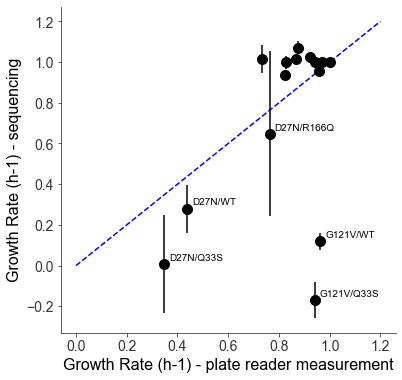

In [15]:
#import the growth rates collected by plate reader measurement
fin = open('Output/2023-04-11_plate_grdata.pkl','rb')
plate_grdata = pickle.load(fin)
fin.close()

#organize the data for comparison
x,xerr,y,yerr,name = [],[],[],[],[]
for i,dmut in enumerate(plate_grdata['DHmut']):
    for j,tmut in enumerate(plate_grdata['TSmut']):
        if ('.' not in dmut) and (tmut in TYMS_mut):
            x.append(plate_grdata['gr_mean'][i,j])
            xerr.append(plate_grdata['gr_std'][i,j])
            if (dmut=='WT'):
                y.append(1)
                yerr.append(0)
                name.append(dmut+'/'+tmut)
            else:
                p = int(dmut[1:-1])-1
                a = AA.index(dmut[-1])
                y.append(gr_mean[tmut][p,a])
                yerr.append(gr_std[tmut][p,a])
                name.append(dmut+'/'+tmut)
                
#create the plot
plt.figure(figsize=(6,6))
plt.errorbar(x,y,xerr=xerr,yerr=yerr,marker='o',color='k',markersize=10,linestyle='')
for k in range(len(x)):
    if y[k] < 0.9:
        plt.text(x[k]+.02,y[k]+.02,name[k],fontsize=10)
plt.plot([0, 1.2],[0, 1.2],'--b')
plt.xlabel('Growth Rate (h-1) - plate reader measurement',fontsize=16)
plt.ylabel('Growth Rate (h-1) - sequencing', fontsize=16)
plt.savefig('Figs/CorrPlate_SeqData.pdf')

### Plot the relationship between growth rate and catalytic activity for the DHFR "calibration curve" mutations

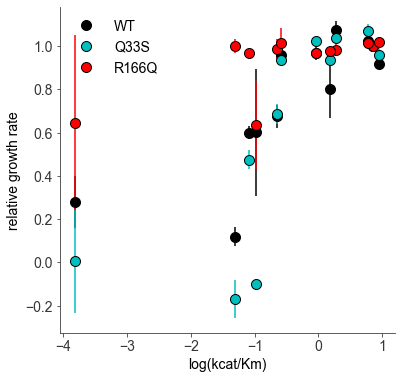

In [16]:
plt.figure(figsize = (6,6))
for i,ts in enumerate(TYMS_mut):
    for mut in calib_mut:
        if mut == 'WT':
            plt.plot(np.log10(dhfr_kcat[mut]/dhfr_Km[mut]),1, 'o',markersize=10,color=ts_col[i], mec='k',label=ts)
        else:
            g = gr_mean[ts][int(mut[1:-1])-1,AA.index(mut[-1])]
            err = gr_std[ts][int(mut[1:-1])-1,AA.index(mut[-1])]
            plt.errorbar(np.log10(dhfr_kcat[mut]/dhfr_Km[mut]),g,yerr=err, marker='o',markersize=10,color=ts_col[i], mec='k')
        

plt.legend()
plt.xlabel('log(kcat/Km)',fontsize=14)
plt.ylabel('relative growth rate',fontsize=14)
plt.savefig('Figs/RelativeGR_TestMut.pdf')

### Plot heat maps of the relative growth rate effects

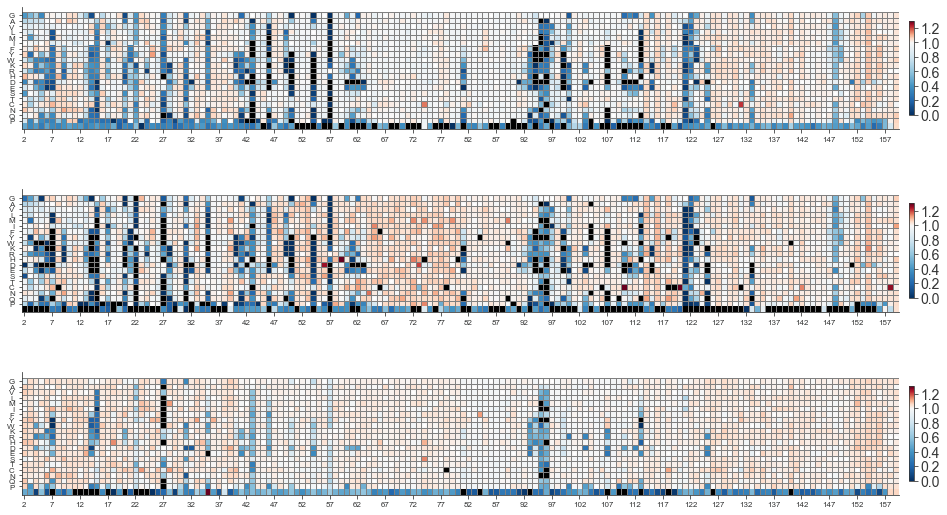

In [17]:
plt.figure(num='h2',figsize = (15,8))
vmn = 0
vmx = 1.3
import matplotlib.colors as colors
norm = colors.TwoSlopeNorm(vmin=vmn, vcenter=1, vmax=vmx)

RdBuR_mod = copy.copy(plt.cm.get_cmap("RdBu_r"))
RdBuR_mod.set_bad(color='k') 

plt.subplot(311)
plt.imshow(gr_mean['WT'][1:,:].T,norm=norm,cmap=RdBuR_mod)
#draw on grey gridlines
for i in range(1,Npos):
    plt.plot([i-0.5,i-0.5],[0-0.5,NAA-.5],'grey',linewidth=1)
for i in range(0,NAA-1):
    plt.plot([-0.5,Npos-1.5],[i-0.52,i-0.52], 'grey',linewidth=1)
#draw a small dot to indicate the WT AA at each postiion:
for i,a in enumerate(wt_aa_seqfull[1:-1]):
    aa_ix = AA.index(a)
    plt.plot(i+0.01,aa_ix,'o',markersize=2,color='white')
plt.colorbar(shrink = 0.5, orientation = 'vertical', pad = 0.01)
plt.xticks(np.arange(0,Npos-1,5),\
                     labels=np.arange(2,Npos,5),fontsize=8)
plt.yticks(np.arange(0,NAA-1),\
                     labels=AA[:-1],fontsize=8)

plt.subplot(312)
plt.imshow(gr_mean['Q33S'][1:,:].T,norm=norm, cmap=RdBuR_mod)
#draw on grey gridlines
for i in range(1,Npos):
    plt.plot([i-0.5,i-0.5],[0-0.5,NAA-.5],'grey',linewidth=1)
for i in range(0,NAA-1):
    plt.plot([-0.5,Npos-1.5],[i-0.52,i-0.52], 'grey',linewidth=1)
#draw a small dot to indicate the WT AA at each postiion:
for i,a in enumerate(wt_aa_seqfull[1:-1]):
    aa_ix = AA.index(a)
    plt.plot(i+.01,aa_ix,'o',markersize=2,color='white')
plt.colorbar(shrink = 0.5, orientation = 'vertical', pad = 0.01)
plt.xticks(np.arange(0,Npos-1,5),\
                     labels=np.arange(2,Npos,5),fontsize=8)
plt.yticks(np.arange(0,NAA-1),\
                     labels=AA[:-1],fontsize=8)

plt.subplot(313)
plt.imshow(gr_mean['R166Q'][1:,:].T,norm=norm, cmap=RdBuR_mod)
#draw on grey gridlines
for i in range(1,Npos):
    plt.plot([i-0.5,i-0.5],[0-0.5,NAA-.5],'grey',linewidth=1)
for i in range(0,NAA-1):
    plt.plot([-0.5,Npos-1.5],[i-0.55,i-0.55], 'grey',linewidth=1)
#draw a small dot to indicate the WT AA at each postiion:
for i,a in enumerate(wt_aa_seqfull[1:-1]):
    aa_ix = AA.index(a)
    plt.plot(i,aa_ix,'o',markersize=2,color='white')
plt.colorbar(shrink = 0.5, orientation = 'vertical', pad = 0.01)
plt.xticks(np.arange(0,Npos-1,5),\
                     labels=np.arange(2,Npos,5),fontsize=8)
plt.yticks(np.arange(0,NAA-1),\
                     labels=AA[:-1],fontsize=8)


plt.tight_layout()
plt.savefig('Figs/RelativeGR_HeatMaps.pdf')

### Examine the distribution of fitness effects for each TYMS background

fit each to a double gaussian and report the mean/variance.

In [18]:
#first, necessary functions for fitting the double gaussian
def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def double_gaussian_fit( params ):
    x = data[0]
    y_proc =data[1]
    fit = double_gaussian( x, params )
    return (fit - y_proc)

343 mutations show growth rates at or below that of nonsense (inactive) variants
Double Gaussian fit for WT TYMS : *******
C1: 429.113, M1 1.003, S1 0.0447
C2: 24.951, M2 0.452, S2 0.3077
329 mutations show growth rates at or below that of nonsense (inactive) variants
Double Gaussian fit for Q33S TYMS : *******
C1: 476.488, M1 1.031, S1 0.0348
C2: 19.606, M2 0.500, S2 0.5003
140 mutations show growth rates at or below that of nonsense (inactive) variants
Double Gaussian fit for R166Q TYMS : *******
C1: 828.601, M1 1.019, S1 0.0271
C2: 13.688, M2 0.500, S2 0.3903


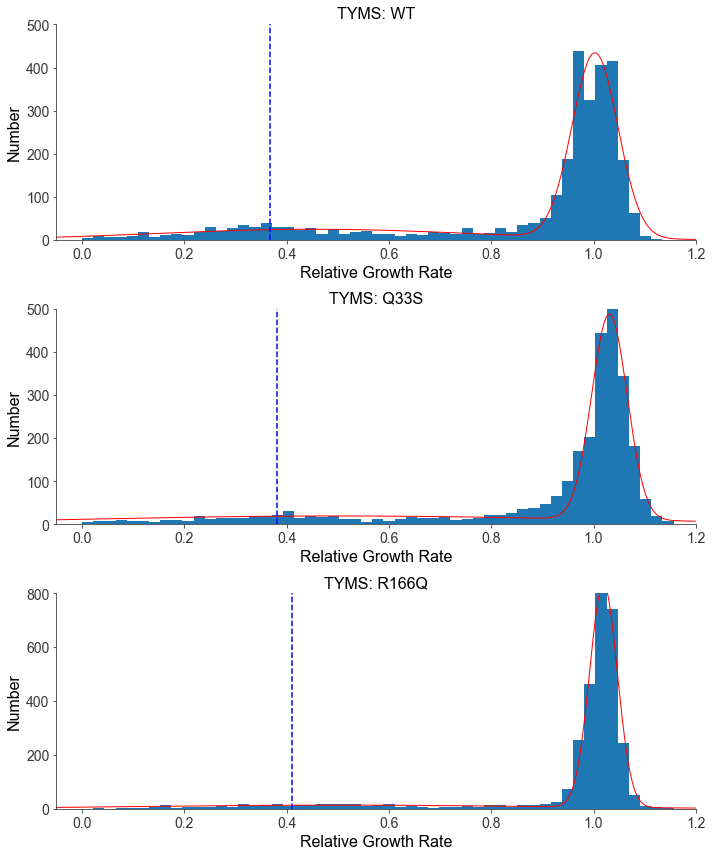

In [19]:
plt.figure(figsize = (10,12))

#freedman-diaconis rule for deciding binwidth (h)
#using the Q33S data since it seems to show
#the most variance in growth rate.
grates_flat = np.ma.array(gr_mean['Q33S'][1:,:],mask=WTAAmask[1:,:],fill_value = np.nan).filled().flatten()
grates_filter = grates_flat[~np.isnan(grates_flat)] 
h = 2*stats.iqr(grates_filter)/(len(grates_filter)**(1/3))
bin_edges = np.arange(0,1.5,h)
ylim_ts = [500, 500, 800]

for i,ts in enumerate(['WT','Q33S','R166Q']):
    plt.subplot(3,1,i+1)
    #filter out the WT entries in the matrix, to prevent overcounting
    grates_flat = np.ma.array(gr_mean[ts][1:,:],mask=WTAAmask[1:,:],fill_value = np.nan).filled().flatten()
    grates_filter = np.append(grates_flat[~np.isnan(grates_flat)],1)
    n,bins,patches = plt.hist(grates_filter,bins=bin_edges)
    
    #fit the double gaussian
    x = [(bins[k]+bins[k+1])/2 for k in range(len(bins)-1)]
    data = [x,n]
    #dgaussfit = leastsq(double_gaussian_fit, [2000,1,0.1,10,0.2,0.3],args=[x,n])
    dgaussfit = least_squares(double_gaussian_fit, [2000,1,0.1,10,0.2,0.3], \
                              bounds=[[0,0.7,0,0,-0.2,0],[2500,1.5,1.0,2500,0.5,1.0]])
    c1=dgaussfit.x[0]; m1=dgaussfit.x[1]; s1=abs(dgaussfit.x[2])
    c2=dgaussfit.x[3]; m2=dgaussfit.x[4]; s2=abs(dgaussfit.x[5])
    plt.plot(np.arange(-0.05,1.2,0.001),\
             double_gaussian(np.arange(-0.05,1.2,0.001),[c1,m1,s1,c2,m2,s2]),'r-',linewidth = 1)
    
    #define a reference line for inactive DHFR variants:
    #the median growth rate for all stop codons across SL1-3
    gr_nonsense = np.nanmedian(gr_mean[ts][1:aa_pos[2][-1],-1])
    plt.plot([gr_nonsense, gr_nonsense],[0,1000],'--b')
    Ninact_mut = np.sum(grates_filter <= gr_nonsense)
    print('%i mutations show growth rates at or below that of nonsense (inactive) variants' % Ninact_mut)
    
    plt.xlim([-0.05,1.2]); 
    #plt.ylim([0,1000])
    plt.ylim([0,ylim_ts[i]])
    plt.xlabel('Relative Growth Rate',fontsize=16); plt.ylabel('Number',fontsize=16)
    plt.title('TYMS: '+ts,fontsize=16)
    
    print('Double Gaussian fit for %s TYMS : *******' % ts)
    print ('C1: %3.3f, M1 %1.3f, S1 %1.4f' % (c1,m1,s1))
    print ('C2: %3.3f, M2 %1.3f, S2 %1.4f' % (c2,m2,s2))

plt.tight_layout()
plt.savefig('Figs/DFEs.pdf')

Text(0, 0.5, 'Number')

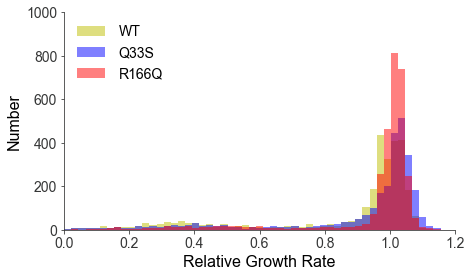

In [20]:
### combine the DFEs onto a single plot to see if this allows a more straightforward comparison

plt.figure(figsize = (7,4))
hist_colors = ['y','b','r']
for i,ts in enumerate(TYMS_mut):
    grates_flat = np.ma.array(gr_mean[ts][1:,:],mask=WTAAmask[1:,:],fill_value = np.nan).filled().flatten()
    grates_filter = np.append(grates_flat[~np.isnan(grates_flat)],1)
    plt.hist(grates_filter,bins=bin_edges,alpha = 0.5,color=hist_colors[i],label=ts)
plt.xlim([0,1.2]); plt.ylim([0,1000])
plt.legend()
plt.xlabel('Relative Growth Rate',fontsize=16); plt.ylabel('Number',fontsize=16)

### Write the fit growth rate data to disk

In [24]:
#first, in pickle (binary) format
gr_data = {}
gr_data['avg'] = gr_mean
gr_data['std'] = gr_std
gr_data['WTAAmask'] = WTAAmask

fout = open('Output/grates.pkl','wb')
pickle.dump(gr_data,fout, protocol=pickle.HIGHEST_PROTOCOL)
fout.close()

#in csv format (for sharing the data more broadly)
fout = open('Output/grates.txt','w')
fout.write('mut\t%s_gr_avg\t%s_gr_std\t%s_gr\t%s_gr_std\t%s_gr\t%s_gr_std\n'% \
           (TYMS_mut[0],TYMS_mut[0],TYMS_mut[1],TYMS_mut[1], \
            TYMS_mut[2],TYMS_mut[2]))

for pos_ix in range(Npos):
    for aa_ix in range(NAA):
        mut = wt_aa_seqfull[pos_ix]+str(pos_ix+1)+AA[aa_ix]
        fout.write('%s\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\t%1.2f\n'%\
                  (mut,gr_mean[TYMS_mut[0]][pos_ix,aa_ix],gr_std[TYMS_mut[0]][pos_ix,aa_ix],\
                  gr_mean[TYMS_mut[1]][pos_ix,aa_ix],gr_std[TYMS_mut[1]][pos_ix,aa_ix],\
                  gr_mean[TYMS_mut[2]][pos_ix,aa_ix],gr_std[TYMS_mut[2]][pos_ix,aa_ix]))
       # fout.write(mut+'\t'+str(gr_mean[TYMS_mut[0]][pos_ix,aa_ix])+'\t' \
       #             +str(gr_std[TYMS_mut[0]][pos_ix,aa_ix])+'\t' \
       #             +str(gr_mean[TYMS_mut[1]][pos_ix,aa_ix])+'\t' \
       #             +str(gr_std[TYMS_mut[1]][pos_ix,aa_ix])+'\t' \
       #             +str(gr_mean[TYMS_mut[2]][pos_ix,aa_ix])+'\t' \
       #             +str(gr_std[TYMS_mut[2]][pos_ix,aa_ix])+'\n') 
        
fout.close()